In [128]:
# General information
classes = ['Esophagus', 'Heart', 'Trachea', 'Aorta']
metrics = ['Dice', 'Sensitivity', 'Specificity', 'Hausdorff', 'Iou', 'Precision', 'Volumetric', 'VOE']
metrics = ['Dice', 'Hausdorff', 'Volumetric']

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import numpy as np
from matplotlib.ticker import MaxNLocator

In [129]:
model = 'samed_fast'

In [130]:
result_location = f'../results_metrics/{model}/metrics3d/'
folders = [result_location + f + '/test_metrics.csv' for f in os.listdir(result_location) if os.path.isdir(os.path.join(result_location, f)) and "crf" not in f]
folders

['../results_metrics/samed_fast/metrics3d/bestweights_samed_512_r6_augment_yes_normalize_no/test_metrics.csv',
 '../results_metrics/samed_fast/metrics3d/bestweights_samed_512_r6_augment_no_normalize_no/test_metrics.csv',
 '../results_metrics/samed_fast/metrics3d/bestweights_samed_512_r6_augment_yes_normalize_yes/test_metrics.csv',
 '../results_metrics/samed_fast/metrics3d/bestweights_samed_512_r6_augment_no_normalize_yes/test_metrics.csv']

/tmp/ipykernel_23889/3214120439.py:61: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Class', y='Mean', hue='Setting', data=metric_df, ax=ax, palette=palette, ci=None, edgecolor='black')
/tmp/ipykernel_23889/3214120439.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_23889/3214120439.py:61: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Class', y='Mean', hue='Setting', data=metric_df, ax=ax, palette=palette, ci=None, edgecolor='black')
/tmp/ipykernel_23889/3214120439.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_23889/321412043

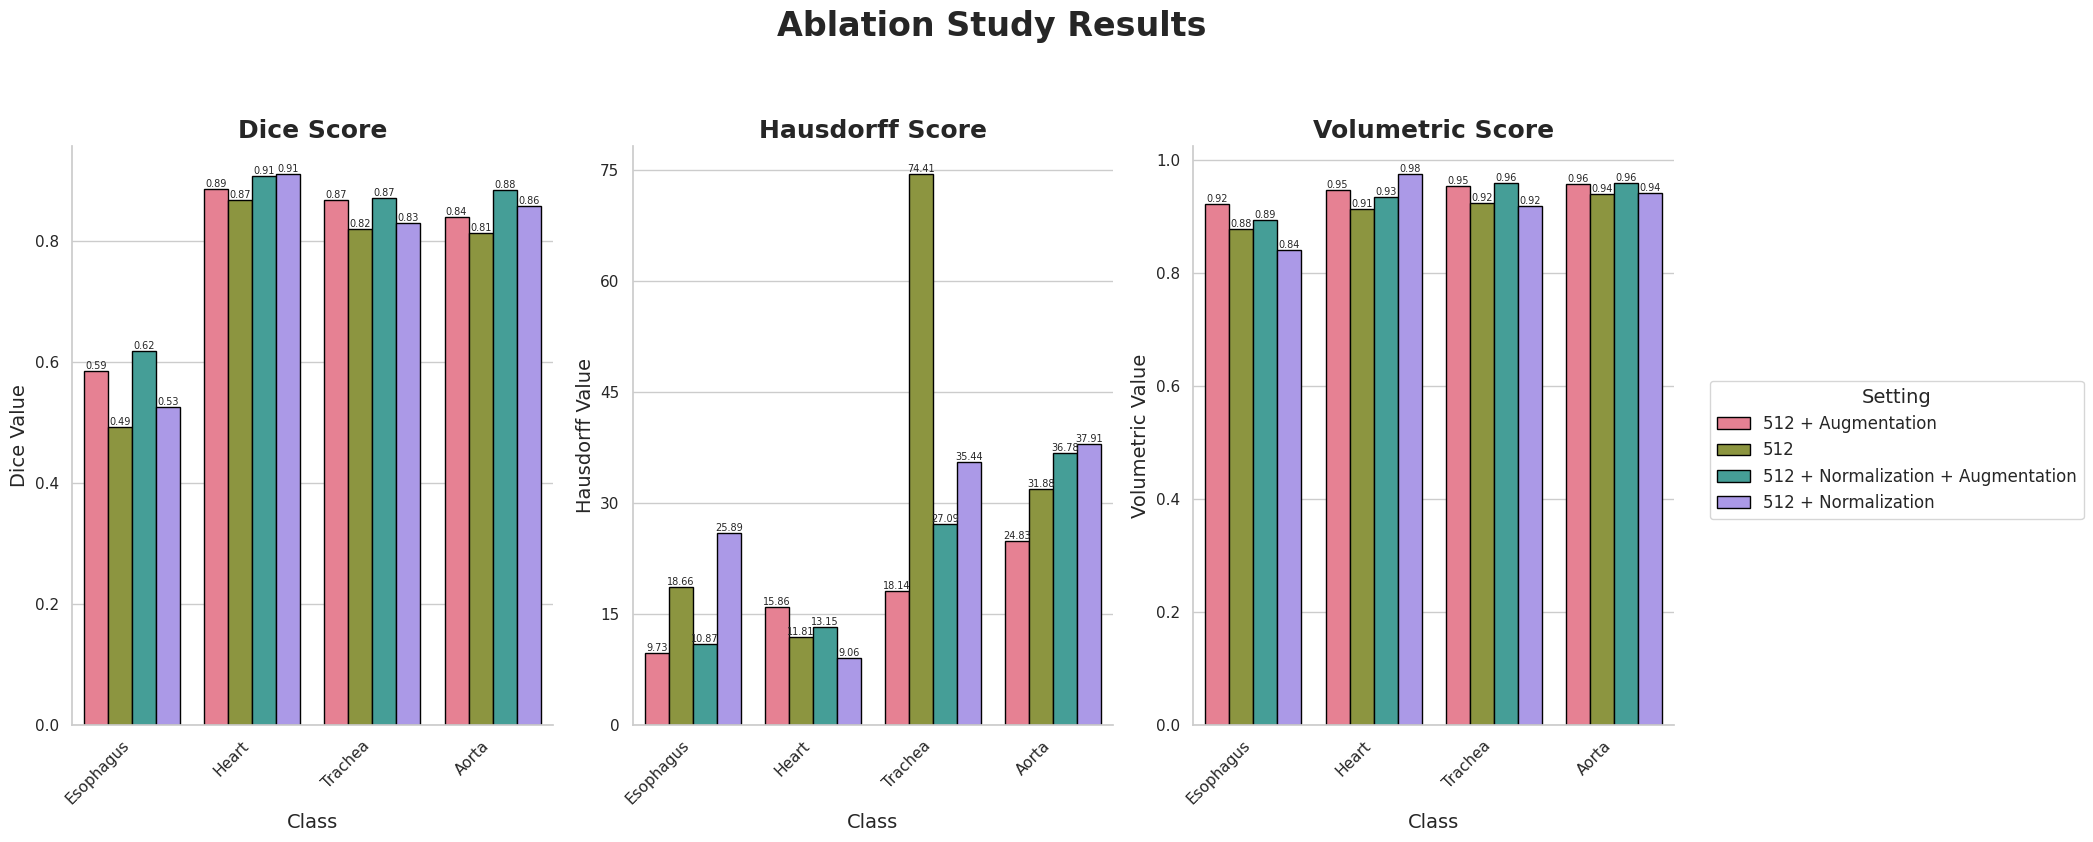

In [131]:
# Collect data in a dictionary to store mean and std for each ablation setting
results = {m: {c: [] for c in classes} for m in metrics}

# Loop through each folder (corresponding to an ablation setting)
for f in folders:
    # Extract folder name components
    info = f.split('_')
    img_size = info[-7]
    norm = info[-2].split('/')[0]
    aug = info[-4]
    
    # Read CSV
    data = pd.read_csv(f, header=0)
    data = data.drop(data.columns[0], axis=1)
    
    # Store results
    for c in classes:
        for metric in metrics:
            class_metric_data = data[(data['class'] == c) & (data['metric_type'] == metric)]
            mean_val = class_metric_data["metric_value"].mean()
            std_val = class_metric_data["metric_value"].std()
            
            # Append mean and std along with ablation setting
            results[metric][c].append({
                'setting': f'{img_size}{" + Normalization" if norm == "yes" else ""}{" + Augmentation" if aug == "yes" else ""}',
                'mean': mean_val,
                'std': std_val
            })

# Set up the plot style
sns.set(style="whitegrid")
sns.set_palette("deep")

# Create subplots with shared y-axis
fig, axes = plt.subplots(1, len(metrics), figsize=(20, 8), sharey=False)
fig.suptitle('Ablation Study Results', fontsize=24, fontweight='bold', y=1.05)

# Color palette for different ablation settings
palette = sns.color_palette("husl", len(folders))

# Set up hatches for better distinction between bars
hatches = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']

for i, metric in enumerate(metrics):
    ax = axes[i]
    
    # Create a DataFrame for each metric
    metric_data = []
    for c in classes:
        for entry in results[metric][c]:
            metric_data.append({
                'Class': c,
                'Setting': entry['setting'],
                'Mean': entry['mean'],
                'Std': entry['std']
            })
    
    metric_df = pd.DataFrame(metric_data)
    
    # Plot barplot with error bars
    sns.barplot(x='Class', y='Mean', hue='Setting', data=metric_df, ax=ax, palette=palette, ci=None, edgecolor='black')

    # Set titles and labels
    ax.set_title(f'{metric} Score', fontsize=18, fontweight='bold')
    ax.set_xlabel('Class', fontsize=14)
    ax.set_ylabel(f'{metric} Value', fontsize=14)

    # Rotate x-axis labels for better readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    # Use MaxNLocator to limit the number of y-axis ticks
    ax.yaxis.set_major_locator(MaxNLocator(nbins=6))

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Add value labels on top of each bar
    for bar in ax.patches:
        if bar.get_height() > 0:
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
                    f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=7)

# Remove individual legends from each subplot
for ax in axes:
    ax.get_legend().remove()

# Add a single legend outside the plot
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.05, 0.5), 
           fontsize=12, title='Setting', title_fontsize=14)

# Adjust layout for clarity
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.savefig('ablation_study_results.png', dpi=300, bbox_inches='tight')
plt.show()